# Least Square Method - 2D

Fitting은 더 큰 차원의 데이터에 대해서도 가능하다. 2차원 데이터를 fitting해보자.

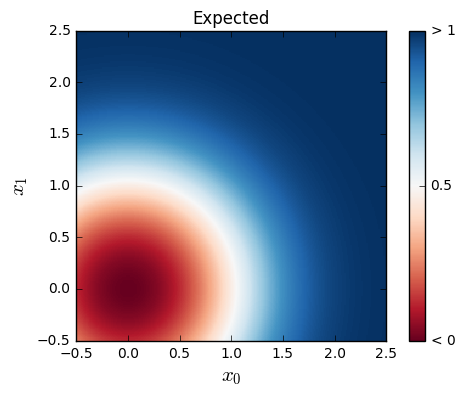

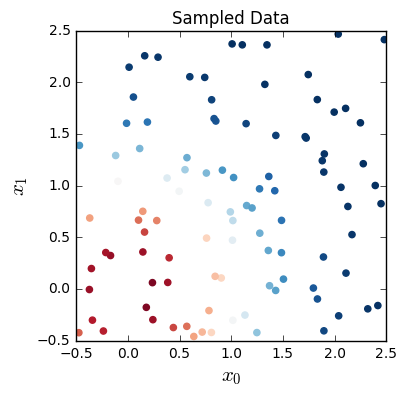

In [1]:
%matplotlib inline

import numpy as np
from numpy import random
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.cm as cm 

cmap = cm.RdBu

def f_exp(x0, x1, coef=None):
    return (1 / (1 + np.exp(-1 * (np.power(x0, 2) + np.power(x1, 2)))) - 0.5) * 2
    
def plot_f(f, opt):
    n = 256 
    x = np.linspace(-0.5, 2.5, n) 
    y = np.linspace(-0.5, 2.5, n) 
    X, Y = np.meshgrid(x, y) 

    Z = f(X, Y, opt['coef'])

    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    ax.axis([-0.5, 2.5, -0.5, 2.5])
    ax.set_title(opt['title'])
    ax.set_xlabel(u'$x_0$', fontsize=15)
    ax.set_ylabel(u'$x_1$', fontsize=15)

    cax = ax.pcolormesh(X, Y, Z, cmap=cmap, vmin=0, vmax=1)
    cbar = fig.colorbar(cax, ticks=[0, 0.5, 1])
    cbar.ax.set_yticklabels(['< 0', '0.5', '> 1'])
    
    return ax

def plot_data(x, f, opt):
    
    if 'ax' in opt:
        ax = opt['ax']
    else:
        fig = plt.figure()
        ax = fig.add_subplot(111, aspect='equal')
        
    ax.axis([-0.5, 2.5, -0.5, 2.5])
    ax.set_title(opt['title'])
    ax.set_xlabel(u'$x_0$', fontsize=15)
    ax.set_ylabel(u'$x_1$', fontsize=15)

    z = f(x[:,0], x[:,1], opt['coef'])
    z = np.squeeze(np.asarray(z))
    
    colors = cmap((z * 256).astype(int))

    ax.scatter(x[:,0], x[:,1], color=colors)
    
    return ax

plot_f(f_exp, {'title':u'Expected', 'coef':None})

random.seed(2)
N = 100
x =  np.dot((random.rand(N,2) - 0.5) * 2, np.array([[1.5, 0], [0, 1.5]])) + np.array([[1, 1]])
z = f_exp(x[:,0], x[:,1])

plot_data(x, f_exp, {'title':u'Sampled Data', 'coef':None})



In [2]:
''' 
x: input data (shape = (N, D))
k: degree of polynomial function (scalar)
retrun: expanded input, [1 x_1 x_2 x^2_1 x^2_2... x^k_1 x^k_2] (shape= (N,1+D*k))
'''
def buildX(x, k):
    X = np.ones((x.shape[0], 1))
    for i in range(k):
        X = np.hstack((X, np.power(x, i + 1)))
    
    return np.matrix(X)

assert(np.array_equal(buildX(np.matrix([[1, 2, 3],[4, 5, 6]]).T, 2), 
       np.matrix([[1, 1, 4, 1, 16], [1, 2, 5, 4, 25], [1, 3, 6, 9, 36]])))

'''
a: coefficients of polynomial function (shape = (1+k, 1))
x: input data (shape = (N, D))
return: f(x:a) (shape = (N, 1))
'''
def evaluate(a, x):
    D = x.shape[1]
    k = (a.shape[0] - 1) / D
    
    X = buildX(x, k)
    f = X.dot(a)
    
    return f

assert(np.array_equal(evaluate(np.matrix([2, 3, 4]).T, np.matrix([[2, 3], [1, 1]])),
                     np.matrix([[20],[9]])))

'''
x0, x1: array (length = N)
a: coefficients (shape=(N,1)) 
'''
def f_poly(x0, x1, a):
    D = 2
    k = (a.shape[0] - 1) / D
    
    f = np.ones_like(x0) * a[0, 0]
    for i in range(k):
        f += a[i * 2 + 1, 0] * x0 ** (i + 1)
        f += a[i * 2 + 2, 0] * x1 ** (i + 1)
        
    return f
    
test_x0 = np.linspace(1, 2, 2) 
test_x1 = np.linspace(0, 3, 2) 
test_X0, test_X1 = np.meshgrid(test_x0, test_x1) 

assert(np.array_equal(
        f_poly(test_X0, test_X1, np.matrix([1, 2, 3]).T),
        np.matrix([[3, 5],[12, 14]])))

'''
d: desired values (shape=(N,1))
o: output (shape=(N,1))
return: half of sum of squred error (shape= (1,1))
'''
def sqrErr(d, o):
    return np.sum(np.power(d - o, 2), 0) / 2.



[Least Squares Fitting - Polynomial](http://mathworld.wolfram.com/LeastSquaresFittingPolynomial.html)  
$a = (X^T X)^{-1} X^T y$

In [3]:

'''
X: expanded input (shape=(N, 1+k*D))
y: expected output (shape=(N, 1))
return: coefficients (shape=(1+k*D, 1))
'''
def fit(X, y):
    a = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y).T
    return a

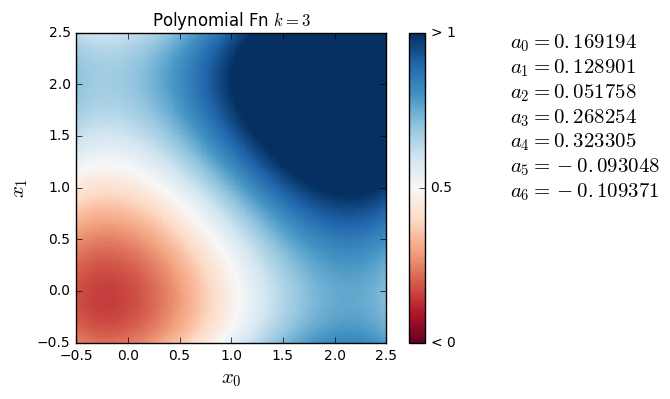

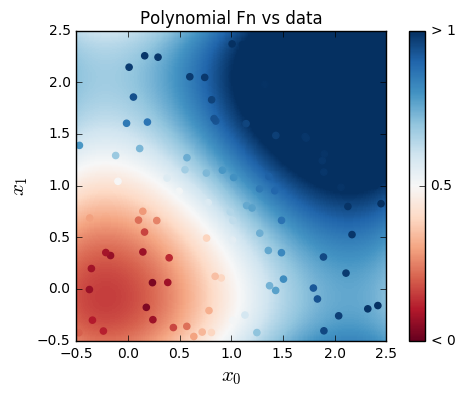

In [4]:
k = 3

X = buildX(x, k)

a = fit(X, z)

ax = plot_f(f_poly, {'title':u'Polynomial Fn $k = %d$' % k, 'coef':a})
ax.text(1.4, 1, '\n'.join('$a_{%d} = %f$' % (i, a[i]) for i in range(a.shape[0])), 
            transform=ax.transAxes, verticalalignment='top', fontsize=15)
    

ax = plot_f(f_poly, {'title':u'', 'coef':a})
ax = plot_data(x, f_exp, {'title':u'Polynomial Fn vs data', 'coef':None, 'ax':ax})


## Least Square Method - 2D - Polynomial + Gradient Descent

In [5]:
def plot_GD(epoch, a, X, y, err):
    ax = plot_f(f_poly, {'title':u'', 'coef':a})
    ax = plot_data(X[:, 1:3], f_exp, {'title':u'Polynomial Fn vs data, epoch = %d' % epoch, 'coef':None, 'ax':ax})

    
    ax.text(1.4, 1, u'$E = %f$' % err, 
                transform=ax.transAxes, fontsize=15)

    ax.text(1.4, 0.95, '\n'.join('$a_{%d} = %f$' % (i, a[i]) for i in range(a.shape[0])), 
                transform=ax.transAxes, verticalalignment='top', fontsize=15)

def fit_GD(X, y, epoch, mu):

    a = np.zeros([X.shape[1], 1])
    
    E = 0
    
    for i in range(epoch):
        
        f = X.dot(a)
        e = y - f
        E = 0.5 * np.sum(np.power(e, 2))

        if (i % (epoch / 10) == 0):
            plot_GD(i, a, X, y, E)

        gradE = - e.T.dot(X).T
        
        a -= mu * gradE.sum(1)


    plot_GD(epoch, a, X, y, E)
    
    return a

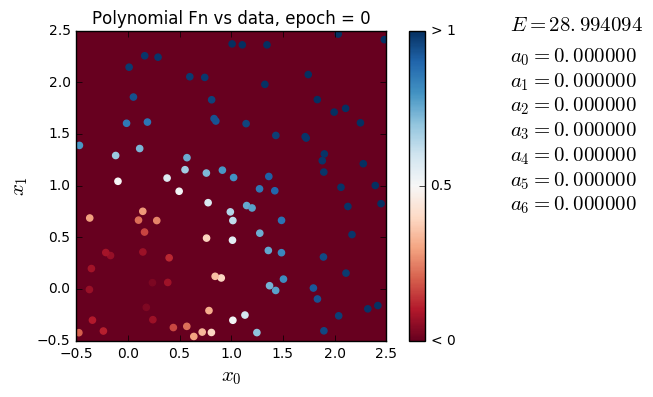

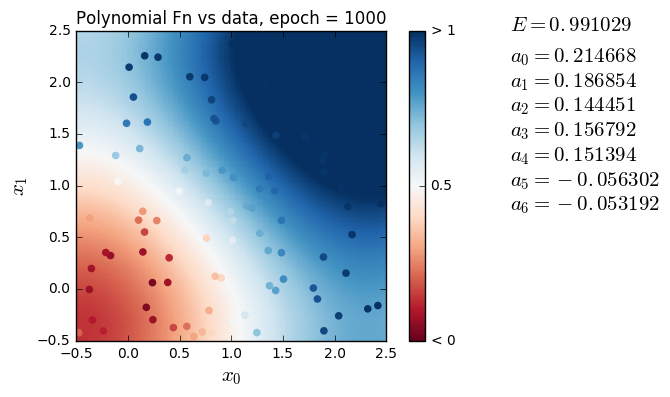

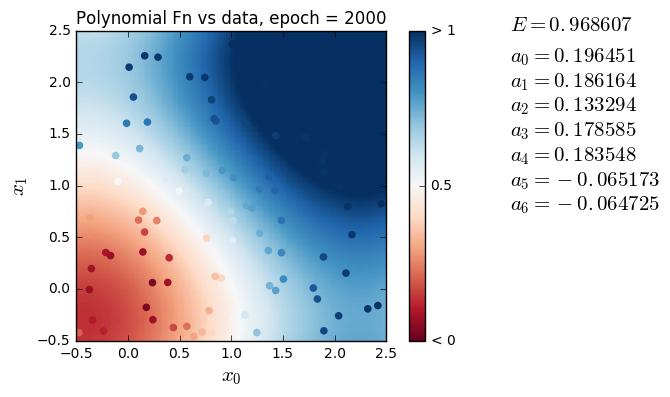

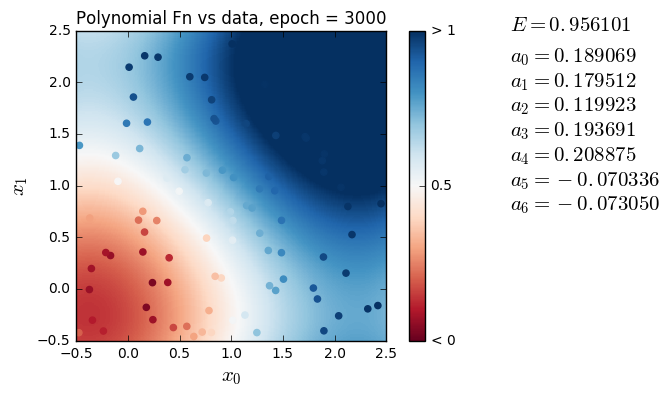

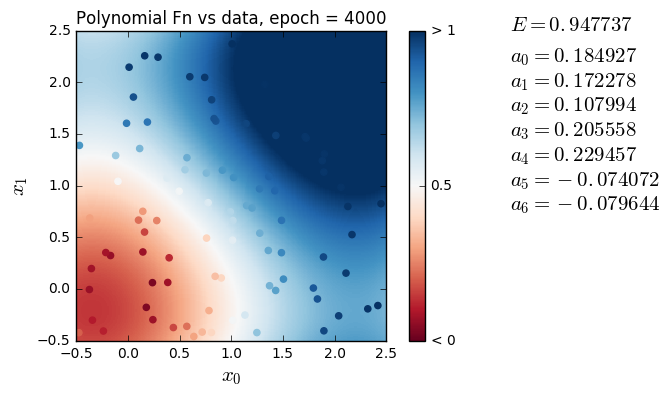

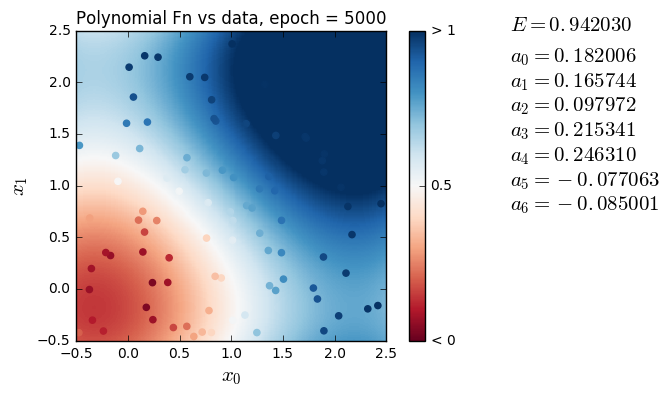

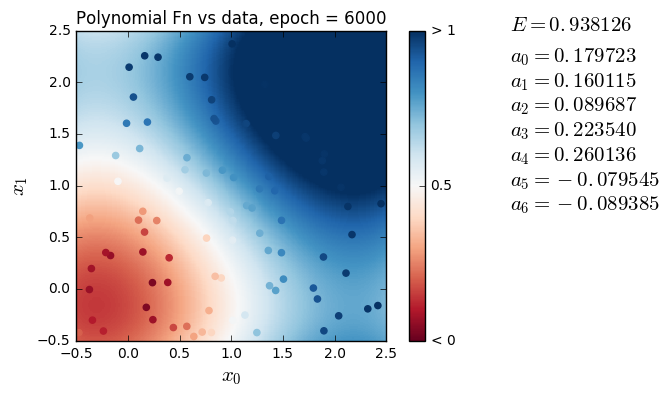

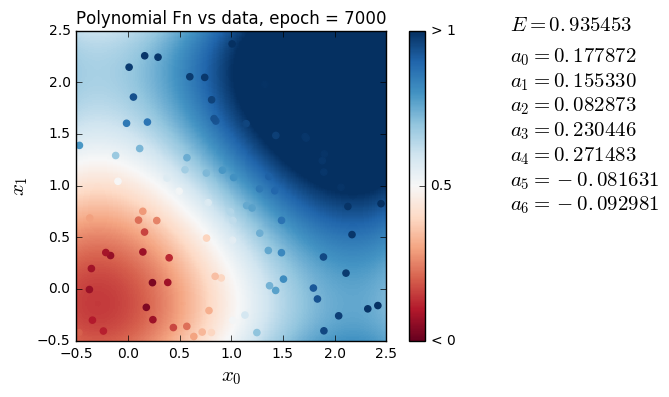

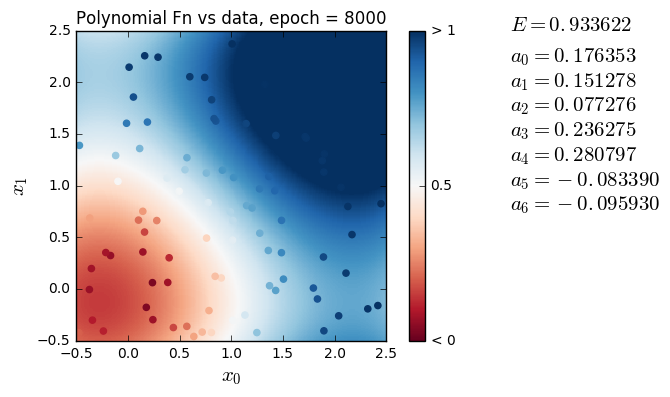

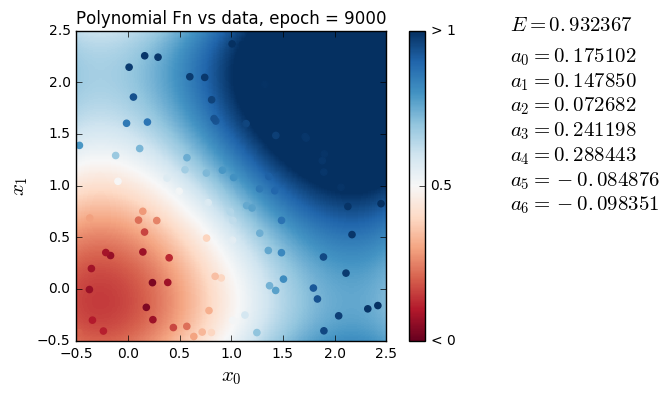

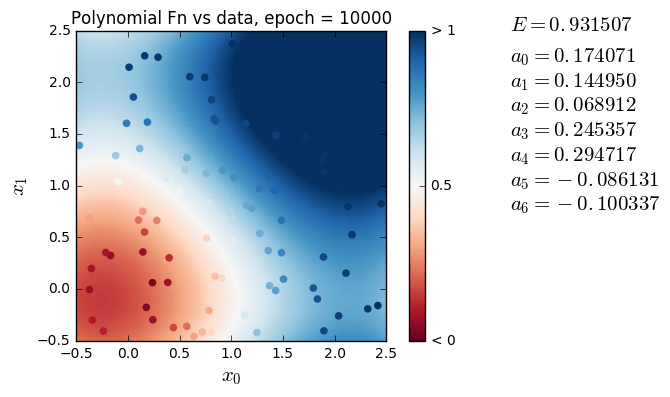

In [6]:
mu = 0.0001 # learning rate (학습 속도)

epoch = 10000 # 반복 횟수

a = fit_GD(X, np.matrix(z).T, epoch, mu)

# Logistic regression - 2D

마찬가지로 2차원 분류 문제도 쉽게 학습할 수 있다.

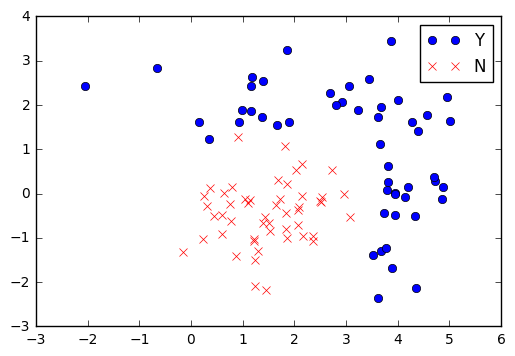

In [7]:
%matplotlib inline

import numpy as np
from numpy import random
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.cm as cm 

# Generate 2D data
N = 100

random.seed(5)

Yes = np.zeros([N/2, 2])
Yes1 = np.random.multivariate_normal([4, 0], [[0.3, 0], [0, 2]], N/4)
Yes2 = np.random.multivariate_normal([2, 2], [[2, 0], [0, 0.3]], N/4)
Yes[:N/4, :] = Yes1
Yes[N/4:, :] = Yes2

No = np.random.multivariate_normal([1.5, -0.5], [[0.5, 0], [0, 0.5]], N/2)

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(Yes[:,0], Yes[:,1], 'o', color='b', label='Y')
# ax.plot(No[:,0], No[:,1], 'x', color='r', label='N')
# ax.set_title(u'Binary Data, N = %d' % N)
# ax.legend()


x = np.zeros([Yes.shape[0] + No.shape[0], 2])
x[:N/2, :2] = Yes
x[N/2:, :2] = No

y = np.zeros([Yes.shape[0] + No.shape[0], 1])
y[:N/2, 0] = 1

#y = np.zeros(Yes.shape[0] + No.shape[0])
#y[:N/2] = 1




def plot_bi_data(x, y, title = u'',
                       markers = [u'x', u'o'], 
                       colors = ['r', 'b'], 
                       labels = [u'N', u'Y'],
                       ax = None):
    idx = [0, 0]
    for i in range(2):
        idx[i] = (np.where(y==i)[0])
    
    if (ax == None):
        ax = plt.figure().add_subplot(111)
        
    for i in (1, 0):
        ax.plot(x[idx[i],0], x[idx[i],1], markers[i], 
                                          color=colors[i], 
                                          label= labels[i]) 
    ax.set_title(title)
    ax.legend()
    
    return ax
    
plot_bi_data(x, y)



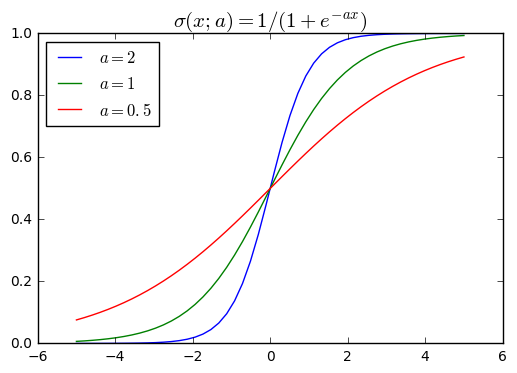

In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-1 * x))

test_x = np.linspace(-5, 5)
ax = plt.figure().add_subplot(111)
ax.plot(test_x, sigmoid(2 * test_x), label='$a=2$')
ax.plot(test_x, sigmoid(test_x), label='$a=1$')
ax.plot(test_x, sigmoid(0.5 * test_x), label='$a=0.5$')
ax.set_title(u'$\sigma (x;a) = 1/(1 + e^{-ax})$', fontsize=15)
ax.legend(loc=2)

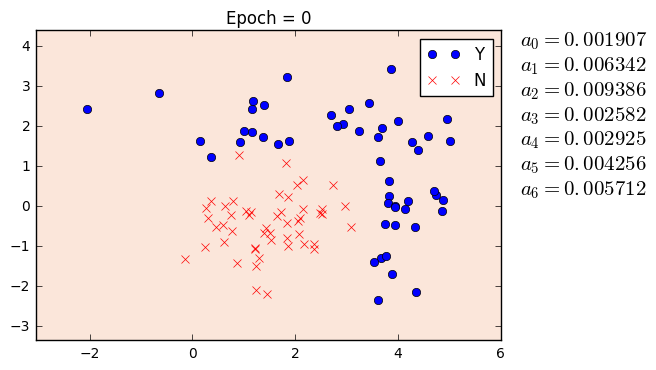

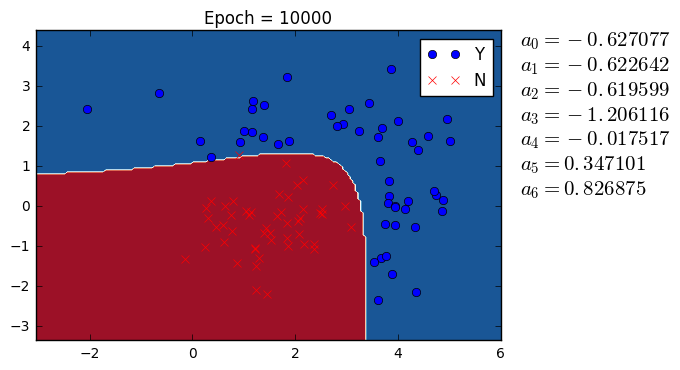

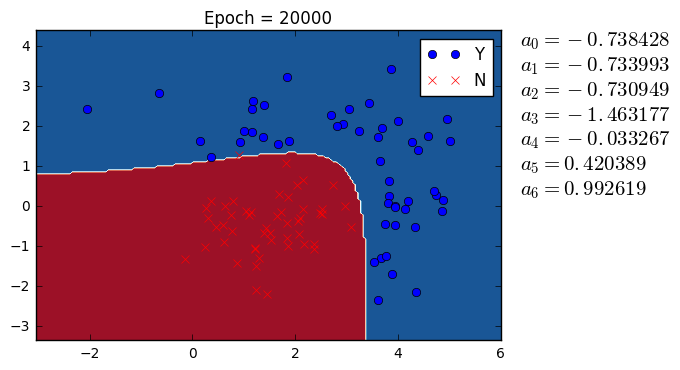

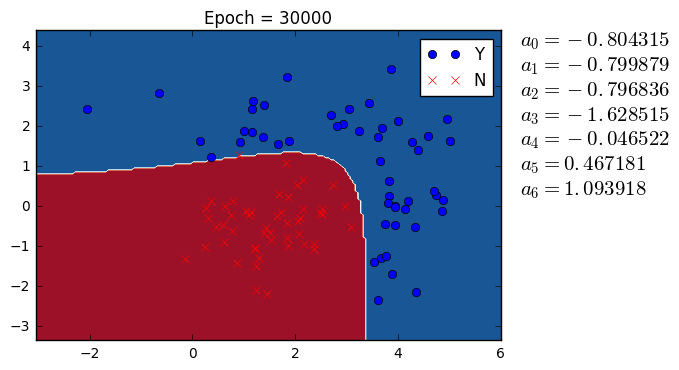

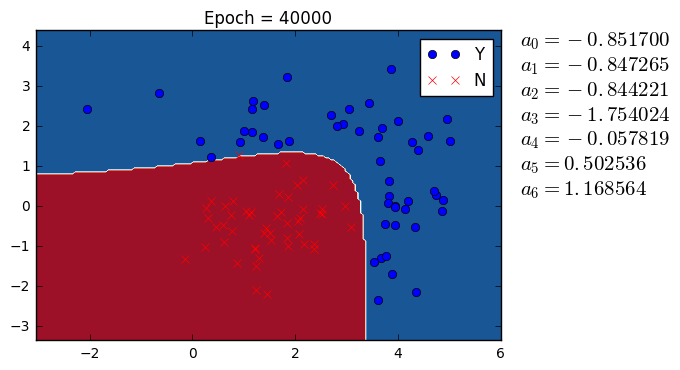

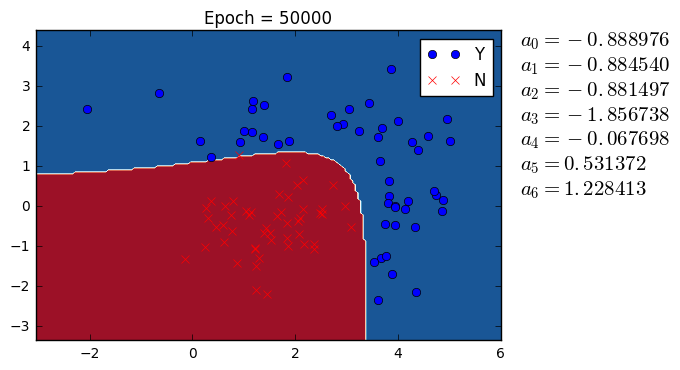

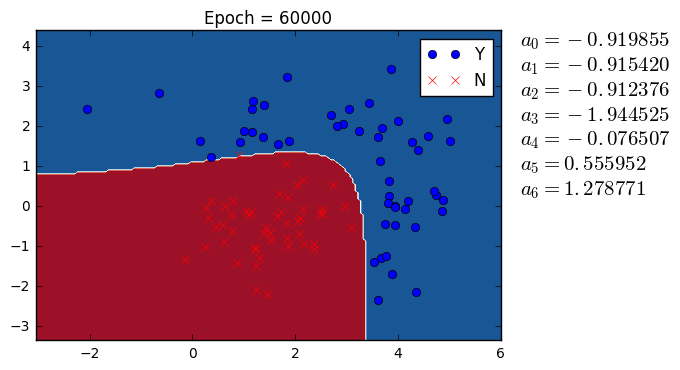

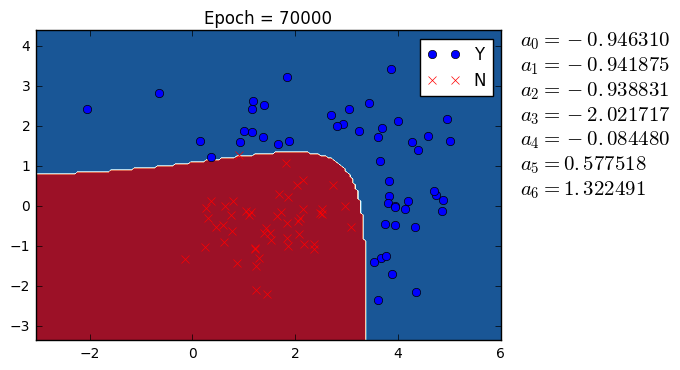

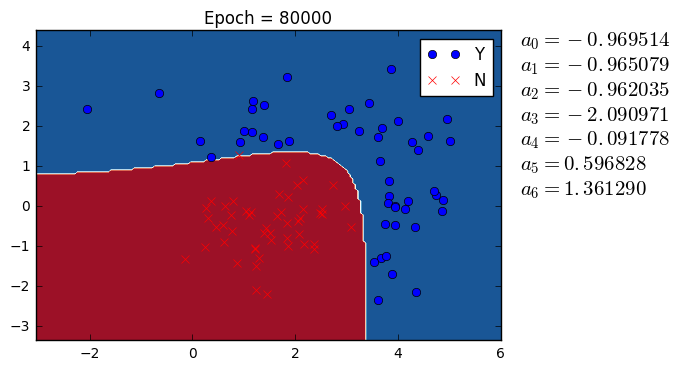

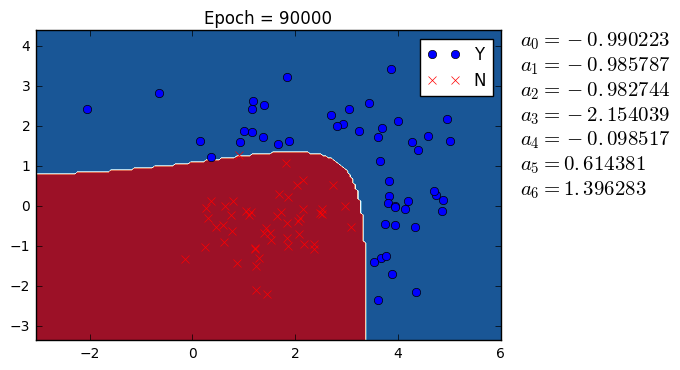

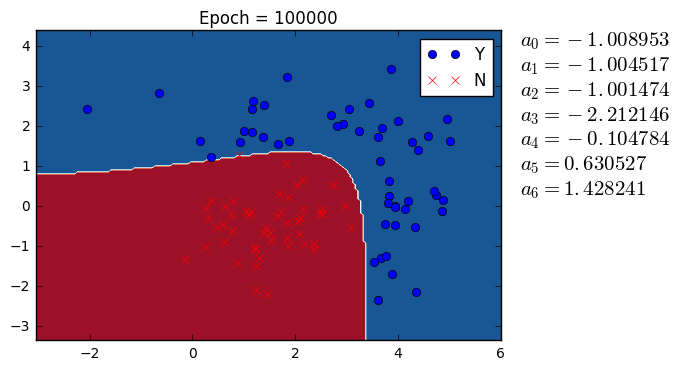

In [9]:
from numpy.testing import assert_array_almost_equal as assertEqual

def evaluate(x, a):
    D = x.shape[1]
    k = (a.shape[0] - 1) / D
    
    X = buildX(x, k)
    f = np.dot(X, a)
    o = sigmoid(f)
    return o

#assertEqual(evaluate(np.matrix([[0, 0],[1, 0],[-3, 1]]), np.matrix([1, 2, 3]).T), 
#           sigmoid(np.matrix([1, 3, -2]).T))

def classify(x, a):
    
    y = np.ones((x.shape[0], 1))
    y[:] = 0.99
    y[evaluate(x, a) <= 0.5] = 0.01
    return y
    
    #return evaluate(x, a) > 0.5

#assertEqual(classify(np.matrix([[0, 0],[1, 0],[-3, 1]]), np.matrix([1, 2, 3]).T),
#            np.matrix([1, 1, 0.1]).T)


def lossFn(x,y,a):
    o = evaluate(x, a);
    
    e = (y - o)
    assert(e.shape == y.shape)
    
    return sum(np.power(e, 2)) / 2.

#assertEqual(lossFn(np.matrix([[0, 0],[1, 0],[2, 1]]), sigmoid(np.matrix([1, 3, 8]).T), np.matrix([1, 2, 3]).T), 
#           0)

def plot_DecisionBoundary(x, clf, opt):
    x0_min, x0_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    x1_min, x1_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    
    h = 0.05
    xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h),
                         np.arange(x1_min, x1_max, h))
    
    yy = clf(np.c_[xx0.ravel(), xx1.ravel()], opt['params'])
    yy = yy.reshape(xx0.shape)
    
    ax = plt.figure().add_subplot(111)
    ax.contourf(xx0, xx1, yy, cmap=cmap)
    
    return ax
    
def plot_LR_GD(x, y, clf, opt):
    ax = plot_DecisionBoundary(x, clf, opt)
    ax = plot_bi_data(x, y, ax=ax)
    
    return ax


def buildX(x, k):
    X = np.ones((x.shape[0], 1))
    for i in range(k):
        #X = np.hstack((X, np.power(x, i + 1)))
        X = np.hstack((X, np.power(i + 1, x)))
        #X = np.hstack((X, np.exp(x * (i+1))))
        #X = np.hstack((X, np.sin(x * (i+1))))
        #X = np.hstack((X, np.cos(x * (i+1))))
    return np.matrix(X)

    
def fit_LR_GD(x, y, k, epoch, mu):
    X = buildX(x, k)
    
    #a = np.zeros([X.shape[1], 1])
    a = random.rand(X.shape[1], 1) * 0.01
    
    for i in range(epoch):
        f = np.dot(X,a)
        o = sigmoid(f)
        e = y - o
        g = np.multiply(o, 1 - o)
        
        if (i % (epoch / 10) == 0):
            ax = plot_LR_GD(x, y, classify, {'params': a})
            ax.set_title(u'Epoch = %d' % i)
            ax.text(1.04, 1, '\n'.join('$a_{%d} = %f$' % (i, a[i]) for i in range(a.shape[0])), 
                        transform=ax.transAxes, verticalalignment='top', fontsize=15)
            
        dE = X.T.dot(-np.multiply(e, g))
        
        assert(dE.shape == a.shape)
        
        a -= mu * dE
        
        
    ax = plot_LR_GD(x, y, classify, {'params': a})
    ax.set_title(u'Epoch = %d' % epoch)
    ax.text(1.04, 1, '\n'.join('$a_{%d} = %f$' % (i, a[i]) for i in range(a.shape[0])), 
                transform=ax.transAxes, verticalalignment='top', fontsize=15)
            
        
k = 3
mu = 0.0001
epoch = 100000
fit_LR_GD(x, y, k, epoch, mu)

# Take-Home Message

### 고차원 데이터도 Fitting 할 수 있다.